In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    confusion_matrix,
    precision_recall_curve
)

In [4]:
df = pd.read_csv("skygeni_sales_data.csv")

In [5]:
df.head()

,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost


In [6]:
df.shape

(5000, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   deal_id           5000 non-null   object
 1   created_date      5000 non-null   object
 2   closed_date       5000 non-null   object
 3   sales_rep_id      5000 non-null   object
 4   industry          5000 non-null   object
 5   region            5000 non-null   object
 6   product_type      5000 non-null   object
 7   lead_source       5000 non-null   object
 8   deal_stage        5000 non-null   object
 9   deal_amount       5000 non-null   int64 
 10  sales_cycle_days  5000 non-null   int64 
 11  outcome           5000 non-null   object
dtypes: int64(2), object(10)
memory usage: 468.9+ KB


In [8]:
df.describe()

,deal_amount,sales_cycle_days
count,5000.000000,5000.000000
mean,26286.492800,63.751800
std,27689.230136,32.731405
min,2002.000000,7.000000
25%,6611.000000,35.750000
50%,14171.500000,64.000000
75%,39062.250000,92.000000
max,100000.000000,120.000000


In [9]:
df.isnull().sum()

deal_id             0
created_date        0
closed_date         0
sales_rep_id        0
industry            0
region              0
product_type        0
lead_source         0
deal_stage          0
deal_amount         0
sales_cycle_days    0
outcome             0
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])

In [12]:
df['won'] = (df['outcome'] == 'Won').astype(int)

In [13]:
df['quarter'] = df['created_date'].dt.to_period('Q')
df['month'] = df['created_date'].dt.to_period('M')

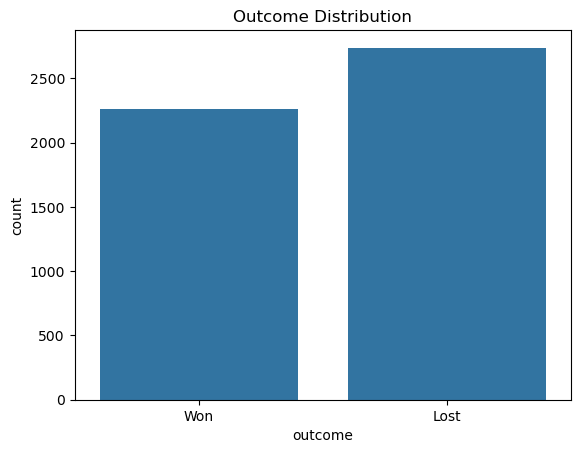

In [14]:
plt.figure()
sns.countplot(x="outcome", data=df)
plt.title("Outcome Distribution")
plt.show()

In [15]:
df['outcome'].value_counts()

outcome
Lost    2737
Won     2263
Name: count, dtype: int64

In [16]:
df['won'].mean()

np.float64(0.4526)

In [17]:
quarterly_perf = df.groupby('quarter').agg({
    'deal_id': 'count',
    'won': 'mean',
    'deal_amount': 'sum'
})
quarterly_perf.columns = ['num_deals', 'win_rate', 'total_revenue']
quarterly_perf

,num_deals,win_rate,total_revenue
quarter,,,
2023Q1,1006,0.437376,25286077
2023Q2,1014,0.442801,27115555
2023Q3,1006,0.466203,26375100
2023Q4,1013,0.479763,26977557
2024Q1,961,0.436004,25678175


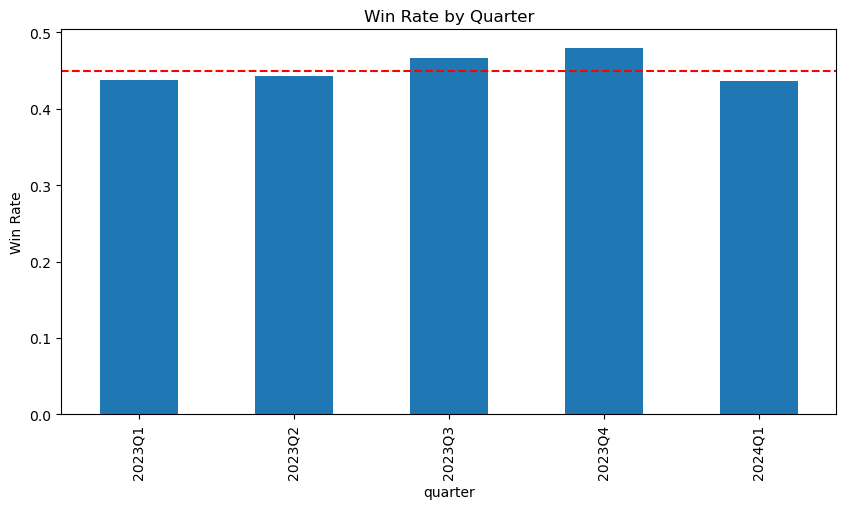

In [18]:
plt.figure(figsize=(10,5))
quarterly_perf['win_rate'].plot(kind='bar')
plt.title('Win Rate by Quarter')
plt.ylabel('Win Rate')
plt.axhline(y=0.45, color='r', linestyle='--')
plt.show()

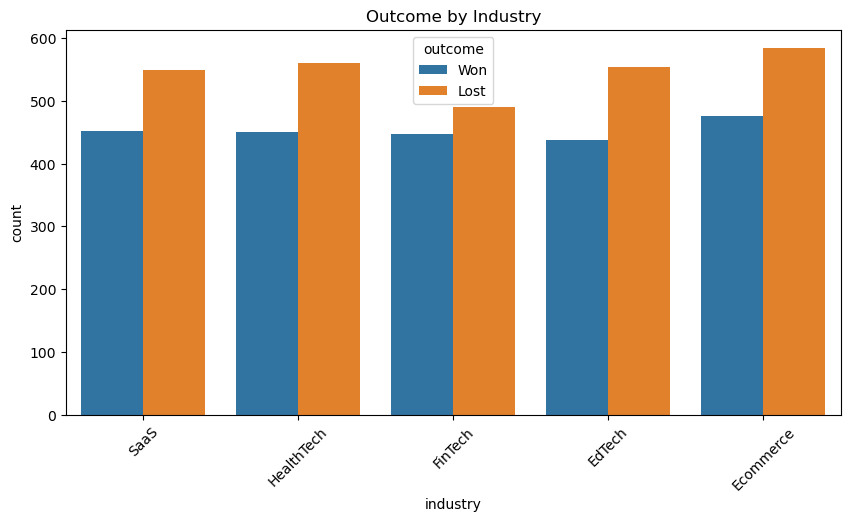

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(x="industry", hue="outcome", data=df)
plt.xticks(rotation=45)
plt.title('Outcome by Industry')
plt.show()

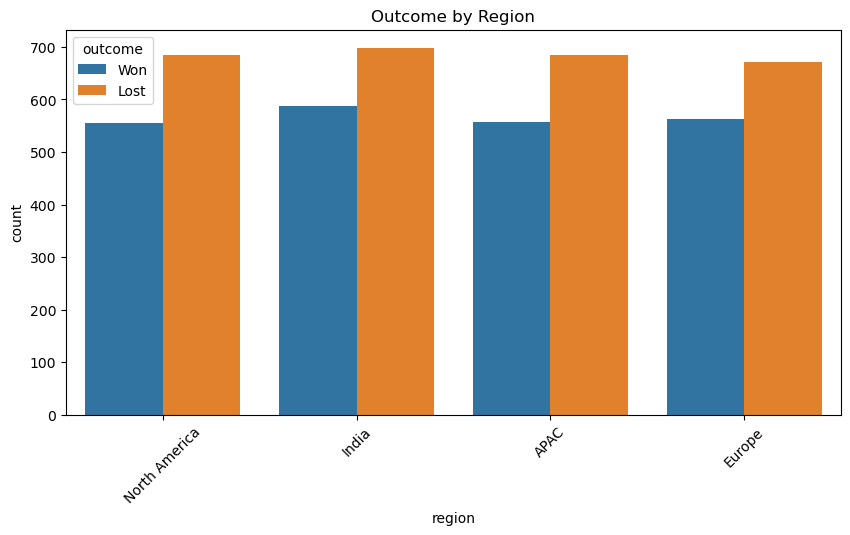

In [20]:
plt.figure(figsize=(10,5))
sns.countplot(x="region", hue="outcome", data=df)
plt.xticks(rotation=45)
plt.title('Outcome by Region')
plt.show()

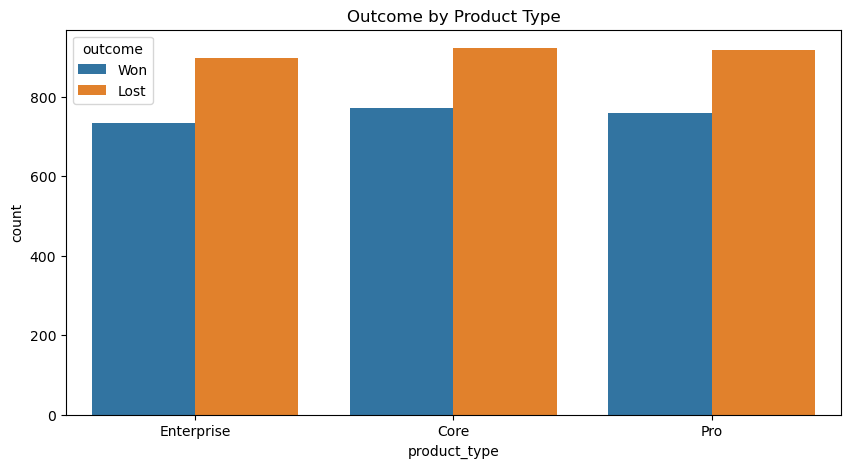

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(x="product_type", hue="outcome", data=df)
plt.title('Outcome by Product Type')
plt.show()

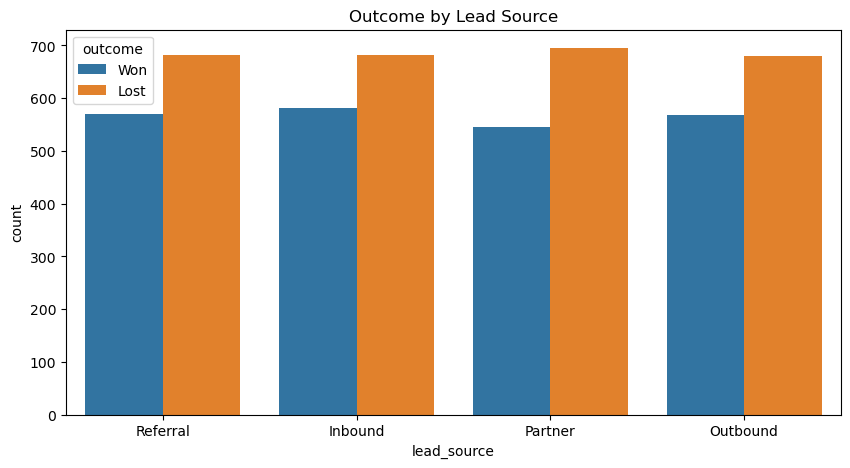

In [22]:
plt.figure(figsize=(10,5))
sns.countplot(x="lead_source", hue="outcome", data=df)
plt.title('Outcome by Lead Source')
plt.show()

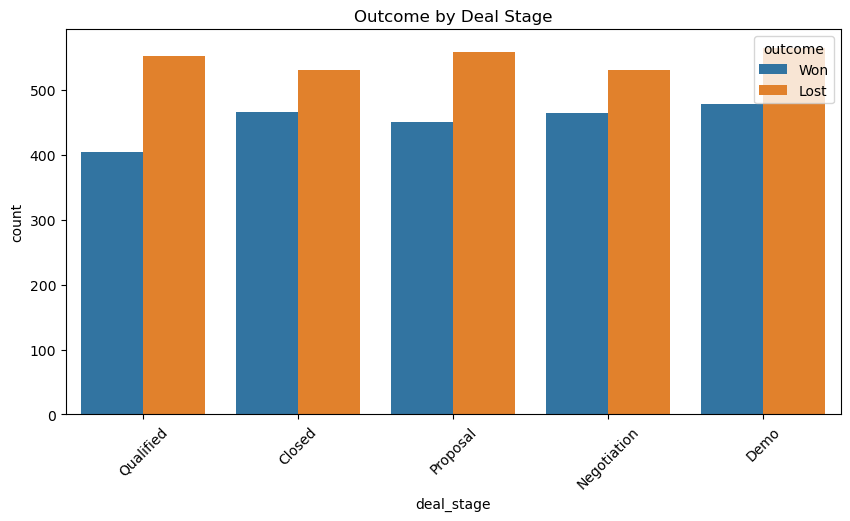

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(x="deal_stage", hue="outcome", data=df)
plt.xticks(rotation=45)
plt.title('Outcome by Deal Stage')
plt.show()

In [24]:
stage_wr = df.groupby('deal_stage')['won'].agg(['mean', 'count'])
stage_wr.columns = ['win_rate', 'count']
stage_wr = stage_wr.sort_values('win_rate', ascending=False)
stage_wr

,win_rate,count
deal_stage,,
Closed,0.467402,997
Negotiation,0.466332,995
Demo,0.458293,1043
Proposal,0.446977,1009
Qualified,0.422594,956


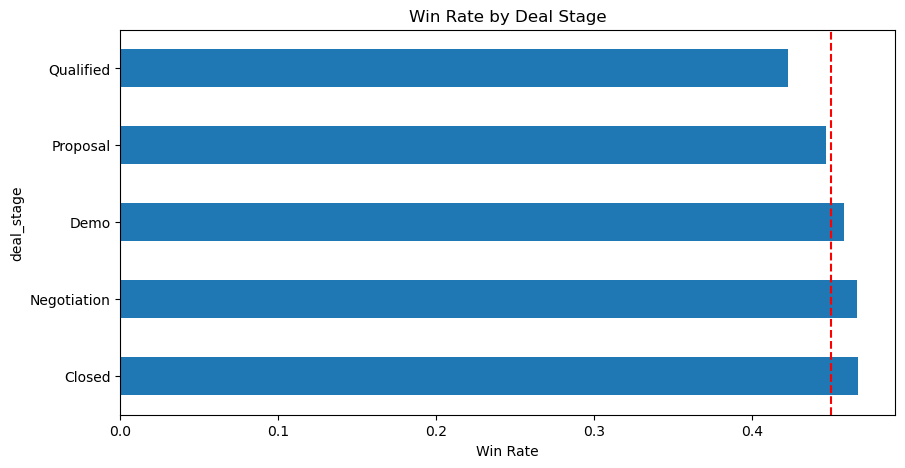

In [25]:
plt.figure(figsize=(10,5))
stage_wr['win_rate'].plot(kind='barh')
plt.title('Win Rate by Deal Stage')
plt.xlabel('Win Rate')
plt.axvline(x=0.45, color='r', linestyle='--')
plt.show()

In [26]:
df['cycle_bucket'] = pd.cut(df['sales_cycle_days'], 
                             bins=[0, 30, 60, 90, 200],
                             labels=['0-30', '31-60', '61-90', '90+'])

In [27]:
cycle_wr = df.groupby('cycle_bucket')['won'].agg(['mean', 'count'])
cycle_wr.columns = ['win_rate', 'count']
cycle_wr

/var/folders/hr/mh6kzvp12034kdd80njjpk9m0000gn/T/ipykernel_92346/3230530942.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cycle_wr = df.groupby('cycle_bucket')['won'].agg(['mean', 'count'])


,win_rate,count
cycle_bucket,,
0-30,0.490768,1029
31-60,0.431732,1311
61-90,0.453532,1345
90+,0.442586,1315


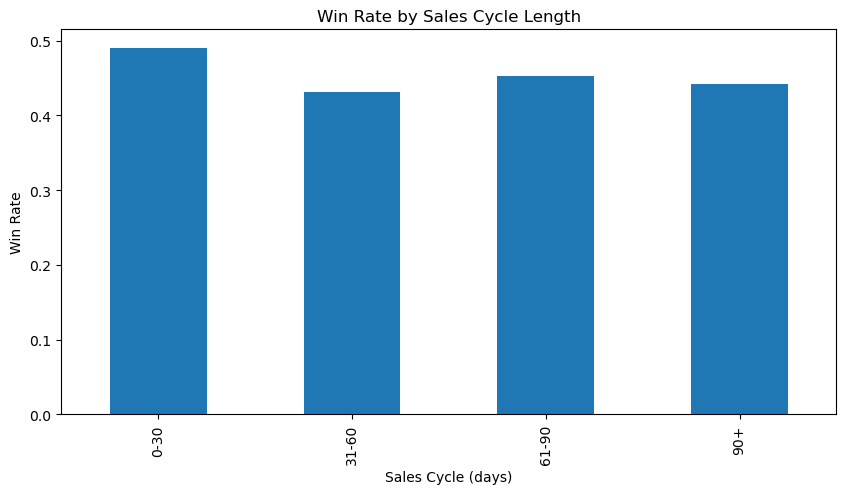

In [28]:
plt.figure(figsize=(10,5))
cycle_wr['win_rate'].plot(kind='bar')
plt.title('Win Rate by Sales Cycle Length')
plt.ylabel('Win Rate')
plt.xlabel('Sales Cycle (days)')
plt.show()

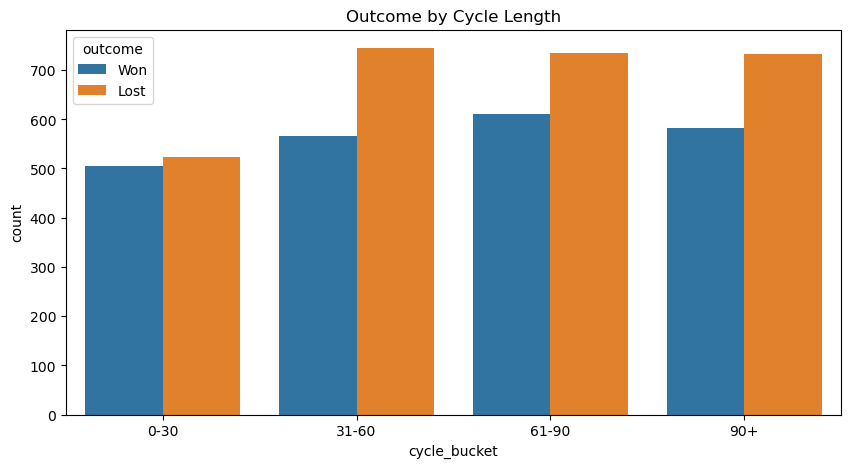

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(x="cycle_bucket", hue="outcome", data=df)
plt.title('Outcome by Cycle Length')
plt.show()

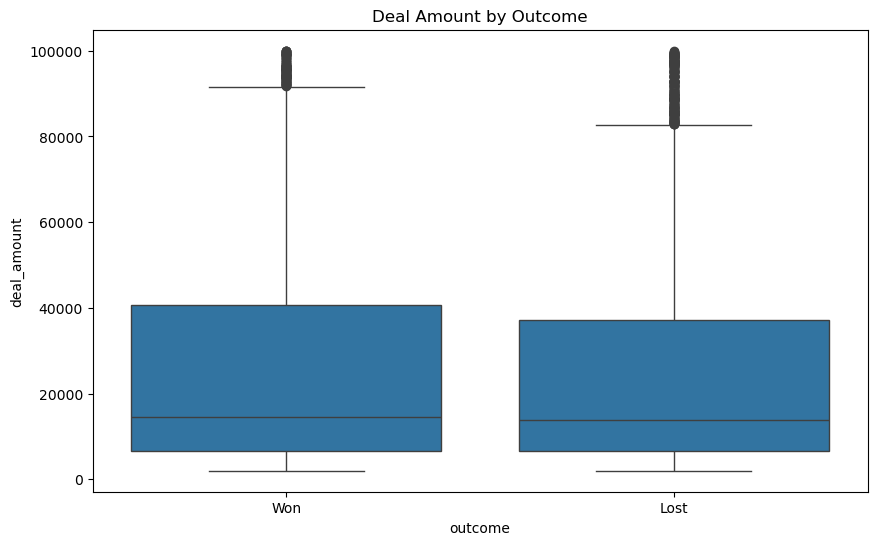

In [30]:
plt.figure(figsize=(10,6))
sns.boxplot(x="outcome", y="deal_amount", data=df)
plt.title('Deal Amount by Outcome')
plt.show()

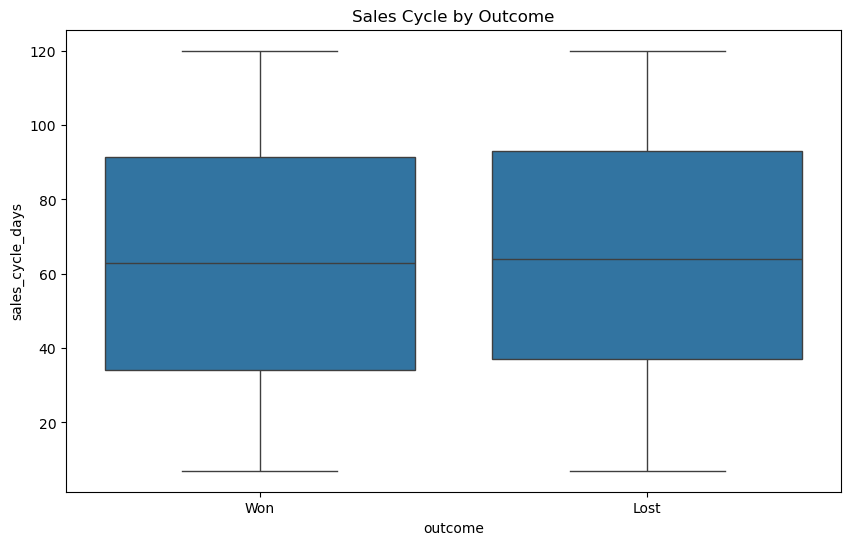

In [31]:
plt.figure(figsize=(10,6))
sns.boxplot(x="outcome", y="sales_cycle_days", data=df)
plt.title('Sales Cycle by Outcome')
plt.show()

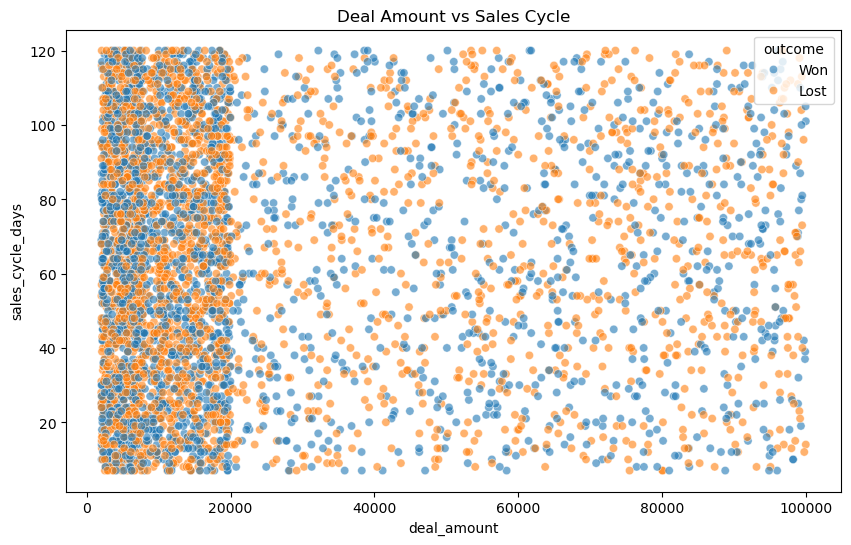

In [32]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="deal_amount", y="sales_cycle_days", hue="outcome", data=df, alpha=0.6)
plt.title('Deal Amount vs Sales Cycle')
plt.show()

In [33]:
pivot_wr = df.pivot_table(values='won', index='lead_source', columns='product_type', aggfunc='mean')
pivot_wr

product_type,Core,Enterprise,Pro
lead_source,,,
Inbound,0.491765,0.476658,0.413953
Outbound,0.438356,0.477157,0.451691
Partner,0.422983,0.395181,0.500000
Referral,0.466825,0.451691,0.447115


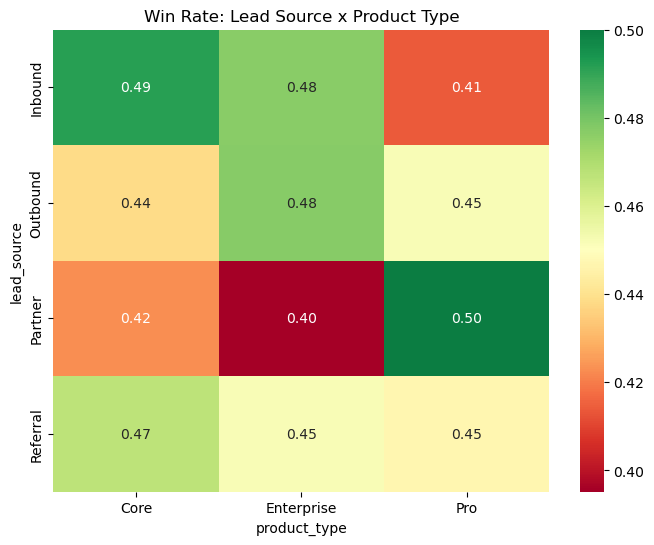

In [34]:
plt.figure(figsize=(8,6))
sns.heatmap(pivot_wr, annot=True, fmt='.2f', cmap='RdYlGn', center=0.45)
plt.title('Win Rate: Lead Source x Product Type')
plt.show()

In [35]:
industry_wr = df.groupby('industry')['won'].agg(['mean', 'count'])
industry_wr.columns = ['win_rate', 'deals']
industry_wr = industry_wr.sort_values('win_rate', ascending=False)
industry_wr

,win_rate,deals
industry,,
FinTech,0.477054,937
SaaS,0.451548,1001
Ecommerce,0.449057,1060
HealthTech,0.445545,1010
EdTech,0.441532,992


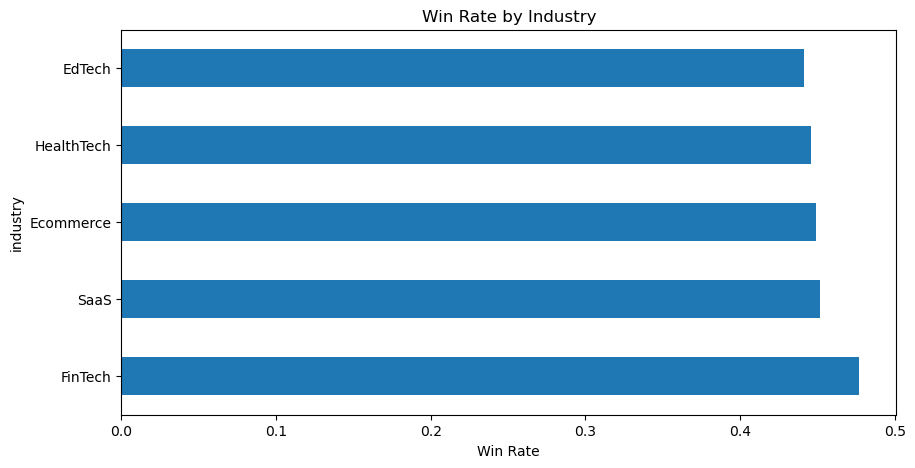

In [36]:
plt.figure(figsize=(10,5))
industry_wr['win_rate'].plot(kind='barh')
plt.title('Win Rate by Industry')
plt.xlabel('Win Rate')
plt.show()

In [37]:
region_wr = df.groupby('region')['won'].agg(['mean', 'count'])
region_wr.columns = ['win_rate', 'deals']
region_wr = region_wr.sort_values('win_rate', ascending=False)
region_wr

,win_rate,deals
region,,
India,0.457232,1286
Europe,0.455799,1233
APAC,0.449275,1242
North America,0.447942,1239


In [38]:
source_wr = df.groupby('lead_source')['won'].agg(['mean', 'count'])
source_wr.columns = ['win_rate', 'deals']
source_wr = source_wr.sort_values('win_rate', ascending=False)
source_wr

,win_rate,deals
lead_source,,
Inbound,0.460380,1262
Referral,0.455272,1252
Outbound,0.455056,1246
Partner,0.439516,1240


In [39]:
efficiency = df.groupby('lead_source').apply(
    lambda x: pd.Series({
        'total_won_revenue': x[x['won']==1]['deal_amount'].sum(),
        'total_days': x['sales_cycle_days'].sum(),
        'num_deals': len(x)
    })
)
efficiency['efficiency_score'] = efficiency['total_won_revenue'] / efficiency['total_days']
efficiency = efficiency.sort_values('efficiency_score', ascending=False)
efficiency

/var/folders/hr/mh6kzvp12034kdd80njjpk9m0000gn/T/ipykernel_92346/2714252957.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  efficiency = df.groupby('lead_source').apply(


,total_won_revenue,total_days,num_deals,efficiency_score
lead_source,,,,
Referral,16250453,80683,1252,201.411115
Inbound,16116715,80367,1262,200.538965
Partner,14129539,76841,1240,183.880207
Outbound,14092571,80868,1246,174.266348


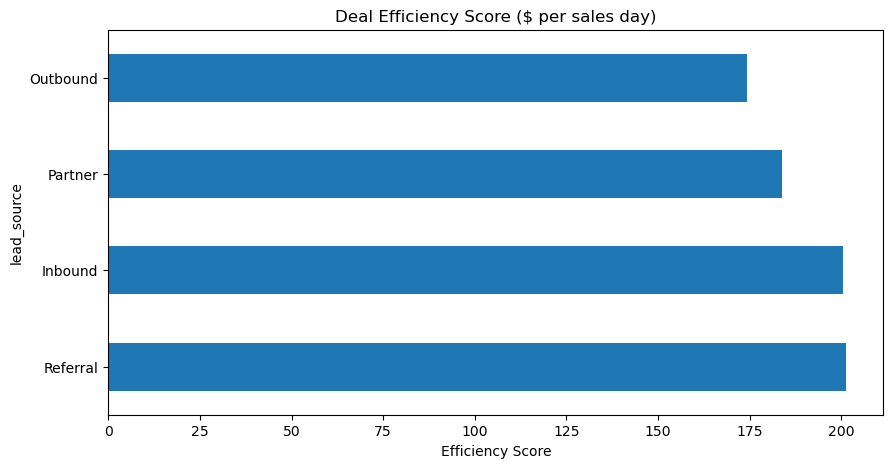

In [40]:
plt.figure(figsize=(10,5))
efficiency['efficiency_score'].plot(kind='barh')
plt.title('Deal Efficiency Score ($ per sales day)')
plt.xlabel('Efficiency Score')
plt.show()

In [41]:
def pipeline_health_index(group):
    win_rate_score = group['won'].mean() * 40
    size_score = min(group['deal_amount'].mean() / 30000, 1.0) * 30
    velocity_score = max(1 - (group['sales_cycle_days'].mean() / 120), 0) * 20
    volume_score = min(len(group) / 50, 1.0) * 10
    health_index = win_rate_score + size_score + velocity_score + volume_score
    
    return pd.Series({
        'health_index': health_index,
        'win_rate': group['won'].mean(),
        'avg_deal_size': group['deal_amount'].mean(),
        'avg_cycle': group['sales_cycle_days'].mean(),
        'num_deals': len(group)
    })

In [42]:
health_by_quarter = df.groupby('quarter').apply(pipeline_health_index)
health_by_quarter

/var/folders/hr/mh6kzvp12034kdd80njjpk9m0000gn/T/ipykernel_92346/2718705382.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  health_by_quarter = df.groupby('quarter').apply(pipeline_health_index)


,health_index,win_rate,avg_deal_size,avg_cycle,num_deals
quarter,,,,,
2023Q1,61.855610,0.437376,25135.265408,64.648111,1006.0
2023Q2,63.806760,0.442801,26741.178501,63.878698,1014.0
2023Q3,64.472432,0.466203,26217.793241,62.360835,1006.0
2023Q4,65.215917,0.479763,26631.349457,63.635735,1013.0
2024Q1,63.450754,0.436004,26720.265349,64.258065,961.0


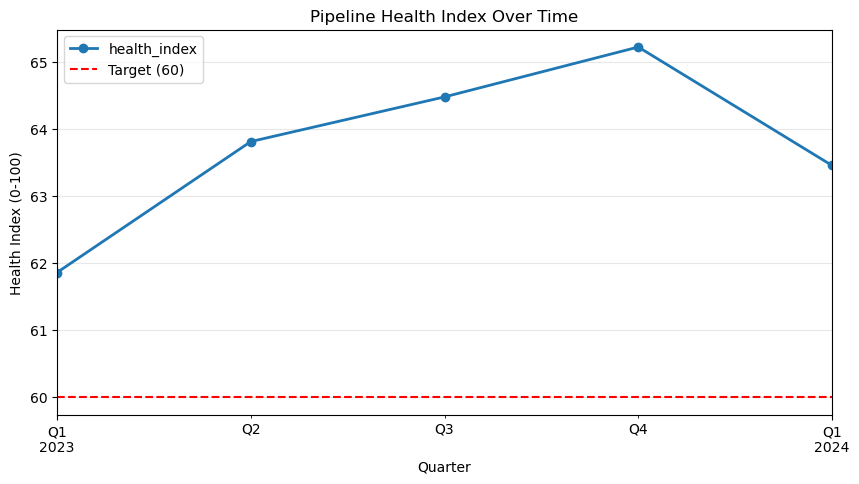

In [43]:
plt.figure(figsize=(10,5))
health_by_quarter['health_index'].plot(kind='line', marker='o', linewidth=2)
plt.axhline(y=60, color='r', linestyle='--', label='Target (60)')
plt.title('Pipeline Health Index Over Time')
plt.ylabel('Health Index (0-100)')
plt.xlabel('Quarter')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [44]:
df.to_csv('deals_cleaned.csv', index=False)